In [1]:
## Créer une représentation de la ville de Brest en cellules de Voronoi

In [16]:
# Importer les packqges nécéssaires

import datetime
import locale
import textwrap

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import overpy
import geopy.distance
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import smopy
%matplotlib inline

# Setting french locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

PLOT_VIGILO_RELEASE_DATE = True
PLOT_VIGILO_PRESS_CONFERENCE_DATE = True

sns.set_style("darkgrid")
sns.set_context("talk", font_scale=0.8)
blue, orange = sns.color_palette("muted", 2)

Lowered zoom level to keep map size reasonable. (z = 13)


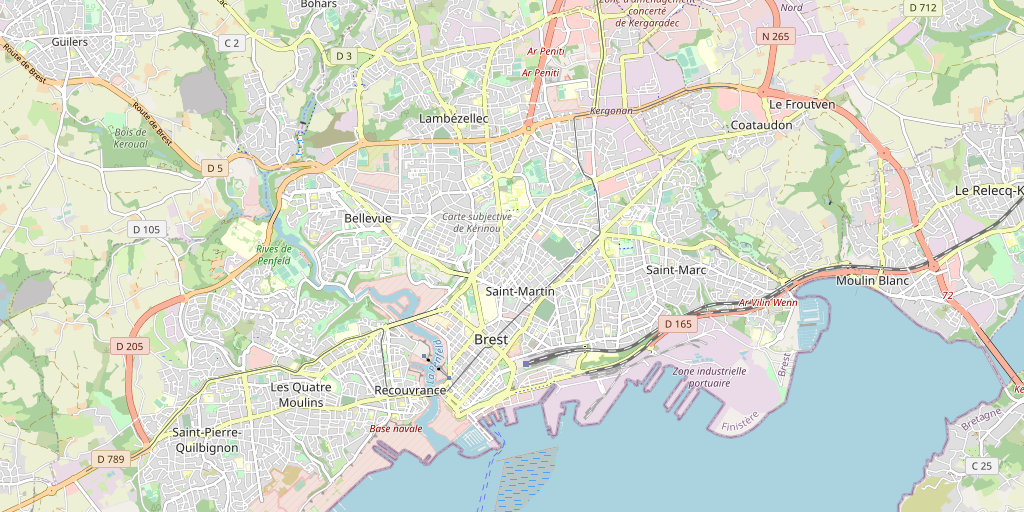

In [36]:
# Obtenir les données

resp = requests.get('https://vigilo.bapav.org/get_issues.php')
df = pd.DataFrame(resp.json())
df = df[df.comment != '']
df.time = pd.to_datetime(df.time, unit='s')
df['julian_day'] = df.time.apply(lambda x: x.timetuple().tm_yday)

# Filtering out data before 2019-01-01
df = df[df.time.apply(lambda x: x.year) > 2020]
df = df.sort_values(by='time', ascending=True)
df = df.reset_index(drop=True)

# Create Box
box = (48.377, -4.556,
       48.416, -4.441)
m = smopy.Map(box, z=20)
m.show_ipython()

In [37]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [38]:
df

token     coordinates_lat      coordinates_lon  \
0    63B7A7EA   48.38148042924211   -4.506968446075916   
1    E1884233   48.38036924572693    -4.52711820602417   
2    72EC1C1C    48.3882109216038   -4.515524357557298   
3    804F509F   48.38291268451501   -4.522987604141236   
4    C3D48540  48.381698476664475   -4.525087684414758   
..        ...                 ...                  ...   
198  6B20FEB7            48.39662             -4.51092   
199  82F5756E   48.40001936279561   -4.453080520033836   
200  312684BF  48.401133456209976   -4.455572627484798   
201  A236E5F7             48.3931              -4.4806   
202  823780C4  48.385679993941025  -4.5013488829135895   

                             address  \
0                rue Beranger, Brest   
1    avenue de l'école navale, Brest   
2              Rue de Guilers, Brest   
3         Rue Alphonse Daudet, Brest   
4             Rue de Keroudot, Brest   
..                               ...   
198          Rue des archives, Brest   
199           Jules Colliere , Brest   
200      rue de la fraternité, Brest   
201                    Branda, Brest   
202             rue Kerveguen, Brest   

                                            comment  \
0         les mêmes tous les matins + 3 en manœuvre   
1       Végétation envahissante à l'angle de la rue   
2                   Dangereux en monté après un feu   
3             Véhicules défonçant des potelets mous   
4    Nombreuses voitures occupant l'unique trottoir   
..                                              ...   
198                          Trottoir problématique   
199                       stationnement très gênant   
200                       stationnement très gênant   
201   Combo passage piéton/trottoir/bande cyclable    
202                  Véhicule garé sur le trottoir    

                                           explanation                time  \
0    Il est urgent de remédier à cette situation, l... 2021-01-08 07:54:00   
1                                                      2021-01-11 12:01:00   
2    Particulièrement compliqué de vérifier la prés... 2021-01-23 13:13:00   
3    Inefficacité programmée. \nQuestion : Pourquoi... 2021-01-27 14:53:00   
4    Où est le trottoir ?\nOù est la place des piét... 2021-02-13 09:45:00   
..                                                 ...                 ...   
198                                                    2023-04-14 09:42:00   
199  stationnement très gênant bloquant les trottoi... 2023-04-16 12:19:00   
200  stationnement très gênant sur espace vert et t... 2023-04-16 12:21:00   
201                                                    2023-04-27 06:54:00   
202    Gêne pour les piétons et la rue en double sens. 2023-04-28 17:04:00   

    status  group categorie approved cityname  julian_day  
0        0      0         2        1    Brest           8  
1        0      0         4        1    Brest          11  
2        0      0         2        1    Brest          23  
3        0      0         3        1    Brest          27  
4        0      0         2        1    Brest          44  
..     ...    ...       ...      ...      ...         ...  
198      0      0         3        1    Brest         104  
199      0      0         2        1    Brest         106  
200      0      0         2        1    Brest         106  
201      0      0         2        1    Brest         117  
202      0      0         2        1    Brest         118  

[203 rows x 13 columns]

In [39]:
df.coordinates_lat

0       48.38148042924211
1       48.38036924572693
2        48.3882109216038
3       48.38291268451501
4      48.381698476664475
              ...        
198              48.39662
199     48.40001936279561
200    48.401133456209976
201               48.3931
202    48.385679993941025
Name: coordinates_lat, Length: 203, dtype: object

In [40]:
df.coordinates_lon

0       -4.506968446075916
1        -4.52711820602417
2       -4.515524357557298
3       -4.522987604141236
4       -4.525087684414758
              ...         
198               -4.51092
199     -4.453080520033836
200     -4.455572627484798
201                -4.4806
202    -4.5013488829135895
Name: coordinates_lon, Length: 203, dtype: object

In [41]:
coos = []
for i in range(len(df.coordinates_lon)):
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])
    coos.append((x, y))

In [42]:
vor = spatial.Voronoi(coos)
regions, vertices = voronoi_finite_polygons_2d(vor)
cells = [m.to_pixels(vertices[region])
         for region in regions]



/home/chenry01/miniconda3/lib/python3.8/site-packages/smopy.py:142: RuntimeWarning: invalid value encountered in log
  ytile = f((1.0 - np.log(np.tan(lat_rad) + (1 / np.cos(lat_rad))) / np.pi) /


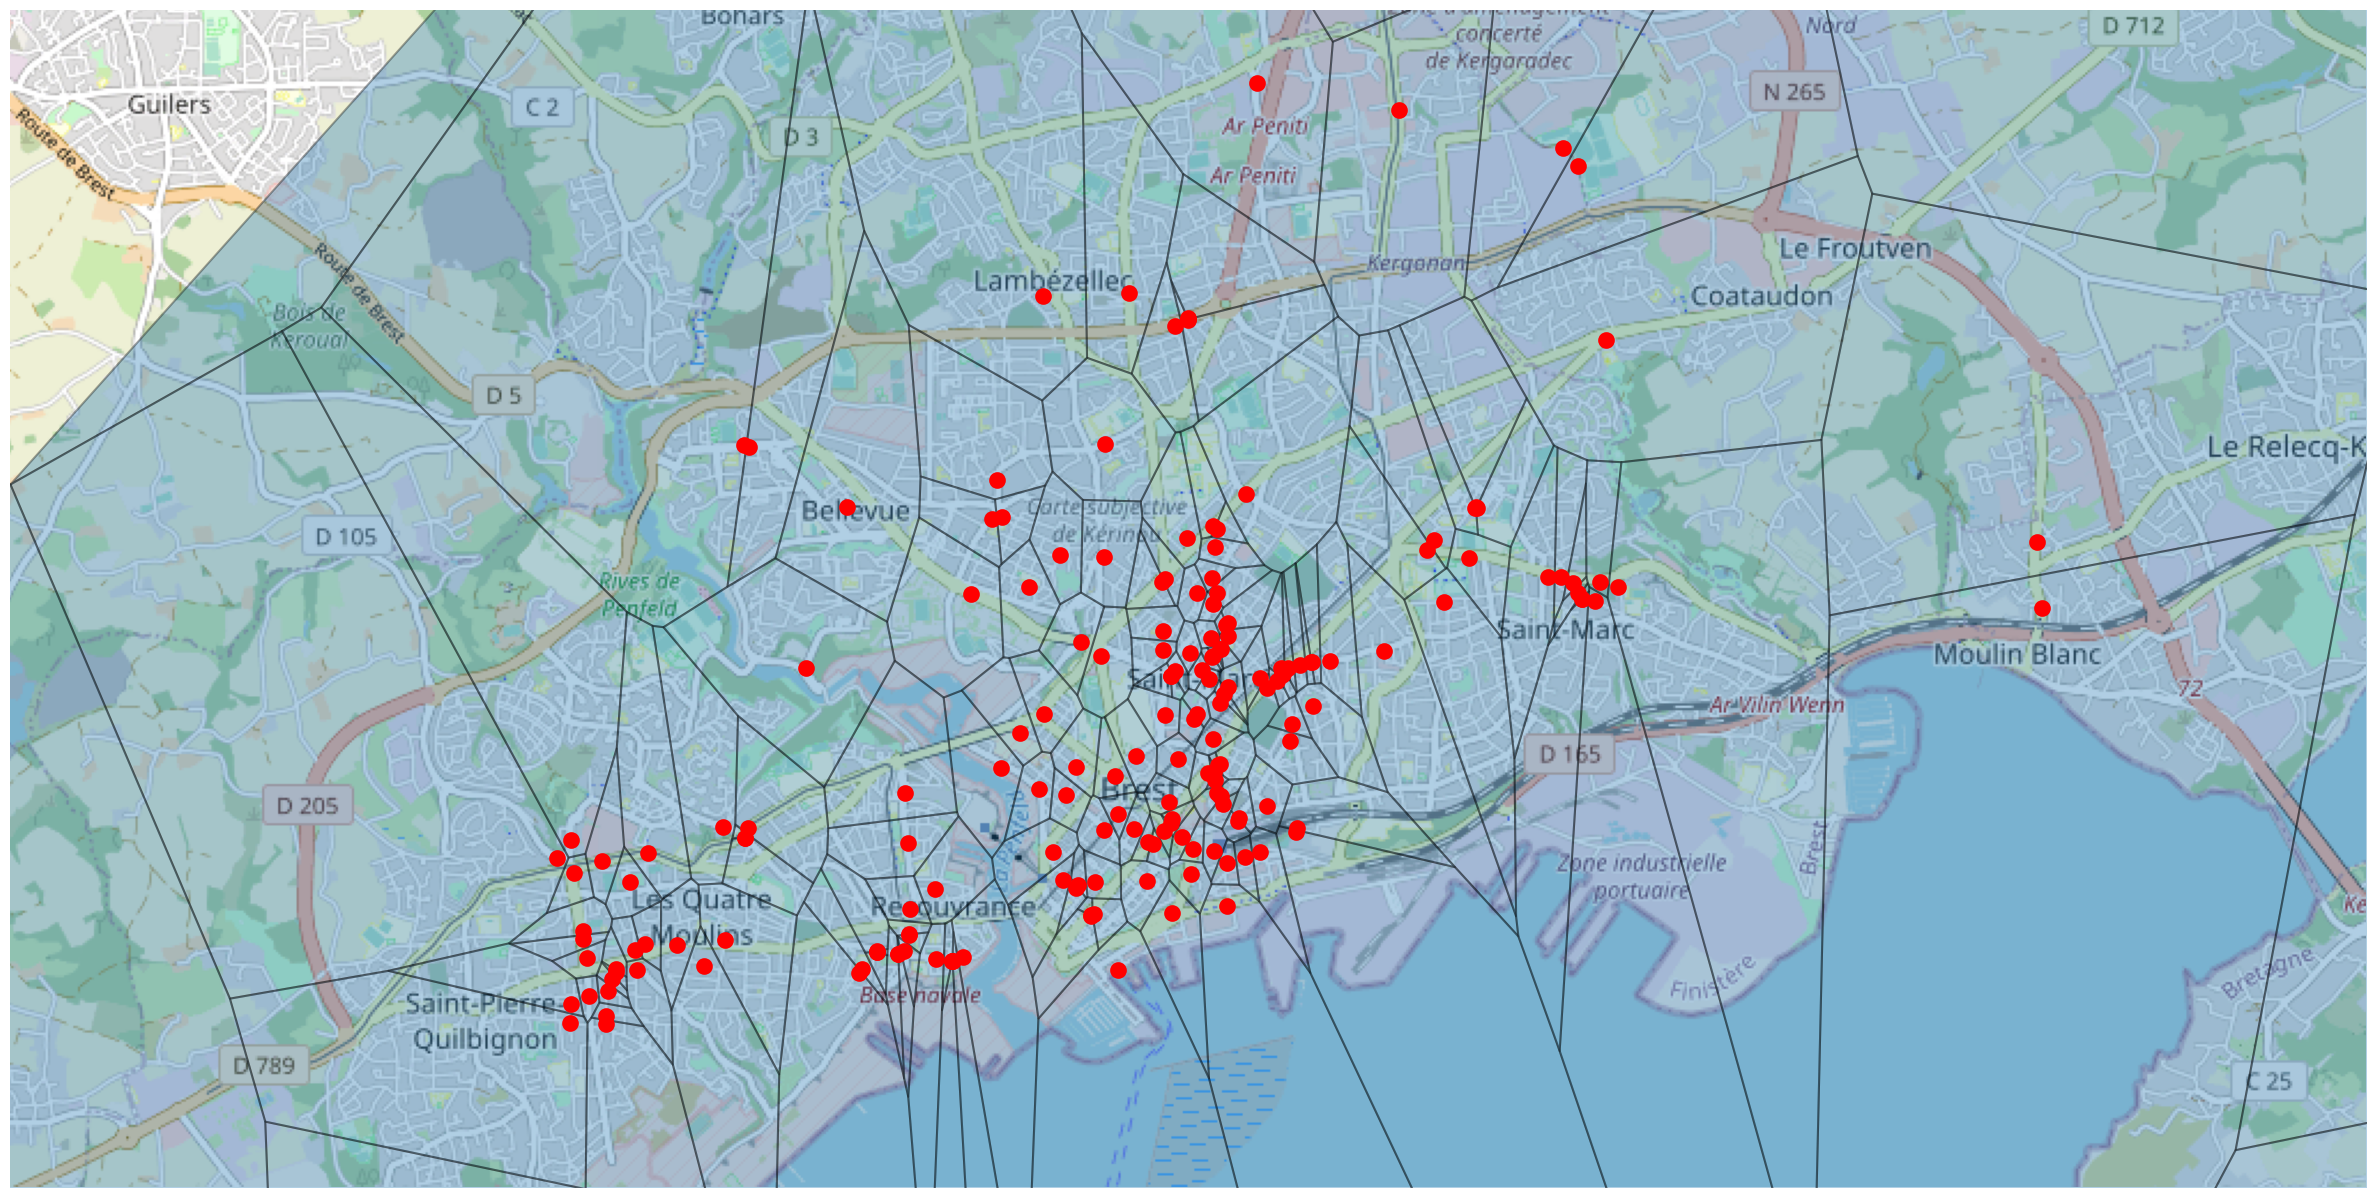

In [43]:
ax = m.show_mpl(figsize=(24, 16))
#x, y = m.to_pixels(48.41392408216084, -4.492457414269447)
#ax.plot(x, y, 'or', ms=10, mew=2);
ax.add_collection(
    mpl.collections.PolyCollection(
        cells,
        edgecolors='k', alpha=.35))
for i in range(len(df.coordinates_lon)):
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])
    xp, yp = m.to_pixels(x,y)
    ax.plot(xp, yp, 'or', ms=10, mew=2)

In [44]:
x

48.385679993941025

In [45]:
y

-4.5013488829135895

In [22]:
regions
vertices[regions[1]]

array([[48.41366873, -4.48292867],
       [48.41387371, -4.48243871],
       [48.41580877, -4.48372309]])

In [20]:
cells[149]

array([[260.39146723, 290.01297595],
       [261.86997755, 289.32339574],
       [268.01240426, 285.06788478],
       [260.80770913, 281.93204457],
       [259.37839767, 283.96932875],
       [257.37277192, 288.23997147],
       [257.62131951, 289.20316618]])

In [119]:
cells

[array([[241.30182966, 314.03458879],
        [239.76661138, 311.44659753],
        [244.95525315, 298.09410356],
        [247.60522525, 298.2299009 ],
        [247.73543309, 299.39381006],
        [247.62028936, 302.91077196],
        [243.5413266 , 312.7930424 ]]),
 array([[254.52385848, 196.16842062],
        [255.95095528, 195.26888567],
        [252.20992458, 186.77713514]]),
 array([[252.20992458, 186.77713514],
        [243.03111317, 150.12885776],
        [246.54014555,  98.07926503],
        [285.51215412, 187.81715905],
        [255.95095528, 195.26888567]]),
 array([[188.07405289, 332.66273713],
        [171.73982381, 334.15057055],
        [170.58975477, 365.88604297],
        [172.30265179, 415.46529959],
        [186.71633865, 443.64852299],
        [190.59513869, 333.40021277]]),
 array([[303.18594957, 316.09968398],
        [270.65574873, 289.93829217],
        [268.75003896, 294.70478598],
        [270.6811265 , 305.49913867],
        [303.94212637, 316.88233837]]),
 a

In [109]:
vertices[regions[1]]

array([[-4.48372309, 48.41580877],
       [-4.48292867, 48.41366873],
       [-4.48243871, 48.41387371]])